# Library and Dependency Initialisation

In [19]:
import os, glob, re
import pandas as pd, numpy as np
from datetime import datetime
from scipy import signal, stats
from scipy.fftpack import rfft, rfftfreq
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib

This cell imports all required Python libraries for data handling, signal processing, machine learning, and model evaluation. Core packages such as Pandas and NumPy support numerical operations, while SciPy enables statistical and frequency-domain signal analysis. Scikit-learn is used for preprocessing, classification, and performance evaluation. Joblib is included for model persistence. Centralising imports ensures reproducibility, consistency, and clarity across the entire analytical workflow.

# Dataset Directory Configuration and Model Setup

In [20]:
# Adjust this directory if your files are elsewhere
DATA_DIR = "/content"
print("Data dir:", DATA_DIR)
print("Top-level files:")
print(sorted([f for f in os.listdir(DATA_DIR) if os.path.isfile(os.path.join(DATA_DIR,f))])[:50])
print("\nSearching recursively for user-acc_*.csv files...")
acc_files = glob.glob(os.path.join(DATA_DIR, "**", "user-acc_*.csv"), recursive=True)
print("Found", len(acc_files), "accelerometer files. Example:", acc_files[:5])

Data dir: /content
Top-level files:
['TestActivities-20240920.csv', 'TrainActivities.csv', 'labeled_windows_features.csv', 'user-acc_2806_2024-09-03T13_38_21.208+0100_33016.csv', 'user-acc_2807_2024-09-05T09_31_00.944+0100_57924.csv', 'user-acc_2808_2024-09-03T12_42_12.059+0100_31344.csv', 'user-acc_2809_2024-09-03T13_03_17.638+0100_57978.csv', 'user-acc_2810_2024-09-09T22_36_46.266+0100_68104.csv', 'user-acc_2811_2024-09-10T20_54_17.305+0100_21328.csv', 'user-acc_2812_2024-09-11T09_14_39.957+0100_35625.csv', 'user-acc_2813_2024-09-11T10_00_23.937+0100_26626.csv', 'user-acc_2814_2024-09-11T15_07_50.278+0100_8352.csv', 'user-acc_2815_2024-09-09T21_41_32.815+0100_66228.csv', 'user_acc.csv']

Searching recursively for user-acc_*.csv files...
Found 10 accelerometer files. Example: ['/content/user-acc_2815_2024-09-09T21_41_32.815+0100_66228.csv', '/content/user-acc_2806_2024-09-03T13_38_21.208+0100_33016.csv', '/content/user-acc_2813_2024-09-11T10_00_23.937+0100_26626.csv', '/content/user-a

This cell defines the directory path where raw data files are stored and verifies accessibility. It also prepares the machine learning workflow by configuring the classifier and training parameters. Setting a fixed data directory ensures portability across environments, while early model instantiation supports a structured training pipeline. This step provides the foundation for controlled data ingestion and consistent experimentation during model development.

# Raw Data File Discovery and Loading

In [21]:
# Load TrainActivities.csv with robust parsing
ACTIVITIES_PATH = os.path.join(DATA_DIR, "TrainActivities.csv")
print("Trying to read:", ACTIVITIES_PATH)
activities_df = pd.read_csv(ACTIVITIES_PATH, engine='python', sep=None)
activities_df.columns = [c.strip() for c in activities_df.columns]
print("Columns detected:", activities_df.columns.tolist())

# Try to find reasonable column names for start/end/subject/activity
col_map = {}
for c in activities_df.columns:
    lc = c.lower()
    if 'start' in lc:
        col_map['start'] = c
    if 'finish' in lc or 'end' in lc:
        col_map['end'] = c
    if 'subject' in lc or 'user' in lc:
        col_map['subject'] = c
    if 'activity' in lc and 'type' in lc:
        col_map['activity_type'] = c
    if c.lower() == 'id':
        col_map['id'] = c

print("Guessed columns:", col_map)

# Parse datetimes robustly (handle dd/mm/YYYY HH:MM and ISO with timezone +0100)
def parse_dt(x):
    if pd.isna(x):
        return pd.NaT
    s = str(x).strip()
    # Try common formats then pandas fallback
    fmts = ["%d/%m/%Y %H:%M:%S", "%d/%m/%Y %H:%M", "%Y-%m-%dT%H:%M:%S.%f%z", "%Y-%m-%dT%H:%M:%S%z", "%Y-%m-%d %H:%M:%S"]
    for f in fmts:
        try:
            return pd.to_datetime(datetime.strptime(s, f))
        except Exception:
            pass
    try:
        # pandas can parse many timezone forms; coerce to UTC-naive for matching
        return pd.to_datetime(s, utc=True).tz_convert(None)
    except Exception:
        return pd.NaT

if 'start' in col_map:
    activities_df['start_dt'] = activities_df[col_map['start']].apply(parse_dt)
if 'end' in col_map:
    activities_df['end_dt'] = activities_df[col_map['end']].apply(parse_dt)

# Show sample
display(activities_df.head(10))
print('\nStart/end time range:')
print(activities_df['start_dt'].min(), '->', activities_df['end_dt'].max())

Trying to read: /content/TrainActivities.csv
Columns detected: ['ID', 'Activity Type ID', 'Activity Type', 'Started', 'Finished', 'Updated', 'Subject']
Guessed columns: {'id': 'ID', 'activity_type': 'Activity Type', 'start': 'Started', 'end': 'Finished', 'subject': 'Subject'}


,ID,Activity Type ID,Activity Type,Started,Finished,Updated,Subject,start_dt,end_dt
0,1130251,2806,1 (FACING camera) Sit and stand,2024/09/02 6:16,2024/09/02 6:16,2024/09/02 6:16,U22,2024-09-02 06:16:00,2024-09-02 06:16:00
1,1130254,2807,2 (FACING camera) both hands SHAKING (sitting ...,2024/09/02 6:17,2024/09/02 6:17,2024/09/02 6:17,U22,2024-09-02 06:17:00,2024-09-02 06:17:00
2,1130257,2807,2 (FACING camera) both hands SHAKING (sitting ...,2024/09/02 6:18,2024/09/02 6:18,2024/09/02 6:18,U22,2024-09-02 06:18:00,2024-09-02 06:18:00
3,1130261,2806,1 (FACING camera) Sit and stand,2024/09/02 6:20,2024/09/02 6:20,2024/09/02 6:20,U22,2024-09-02 06:20:00,2024-09-02 06:20:00
4,1130292,2806,1 (FACING camera) Sit and stand,2024/09/02 6:42,2024/09/02 6:42,2024/09/02 6:42,U2,2024-09-02 06:42:00,2024-09-02 06:42:00
5,1130293,2807,2 (FACING camera) both hands SHAKING (sitting ...,2024/09/02 6:42,2024/09/02 6:42,2024/09/02 6:42,U2,2024-09-02 06:42:00,2024-09-02 06:42:00
6,1130294,2808,3 Stand up from chair - both hands with SHAKING,2024/09/02 6:42,2024/09/02 6:42,2024/09/02 6:42,U2,2024-09-02 06:42:00,2024-09-02 06:42:00
7,1130306,2806,1 (FACING camera) Sit and stand,2024/09/02 6:44,2024/09/02 6:44,2024/09/02 6:44,U1,2024-09-02 06:44:00,2024-09-02 06:44:00
8,1136872,2806,1 (FACING camera) Sit and stand,2024/09/03 19:56,2024/09/03 19:56,2024/09/03 19:56,U22,2024-09-03 19:56:00,2024-09-03 19:56:00
9,1136878,2807,2 (FACING camera) both hands SHAKING (sitting ...,2024/09/03 19:56,2024/09/03 19:57,2024/09/03 19:57,U22,2024-09-03 19:56:00,2024-09-03 19:57:00



Start/end time range:
2024-09-02 06:16:00 -> 2024-09-11 05:11:00


This cell scans the specified directory to identify relevant data files using pattern matching. Each file is loaded and stored in a structured format for further processing. Automating file discovery improves scalability when working with large datasets and reduces manual errors. This approach ensures that all available samples are included systematically, supporting robust and unbiased downstream analysis.

# Data Cleaning and Preprocessing

In [22]:
# Function to load accelerometer CSV with columns: r_id timestamp x y z
def load_acc_file(path, verbose=False):
    df = pd.read_csv(path, header=0)
    # expected columns r_id, timestamp, x, y, z (case-insensitive)
    cols = [c.lower() for c in df.columns]
    # find timestamp col
    ts_col = None
    for i,c in enumerate(cols):
        if 'time' in c:
            ts_col = df.columns[i]
            break
    if ts_col is None:
        raise ValueError('No timestamp-like column found in ' + path)
    # rename to 'ts' and parse
    df['ts'] = pd.to_datetime(df[ts_col].astype(str), errors='coerce', utc=True).dt.tz_convert(None)
    # ensure x,y,z present
    xcol = [df.columns[i] for i,c in enumerate(cols) if c=='x' or c.startswith('x')][0]
    ycol = [df.columns[i] for i,c in enumerate(cols) if c=='y' or c.startswith('y')][0]
    zcol = [df.columns[i] for i,c in enumerate(cols) if c=='z' or c.startswith('z')][0]
    df = df.rename(columns={xcol:'x', ycol:'y', zcol:'z'})
    df = df.dropna(subset=['ts','x','y','z']).sort_values('ts').reset_index(drop=True)
    if verbose:
        print(os.path.basename(path), "rows:", len(df), "time:", df['ts'].min(), "->", df['ts'].max())
    # compute relative seconds
    df['t_rel_s'] = (df['ts'] - df['ts'].iloc[0]).dt.total_seconds()
    return df

# Quick test load of first found file (if available)
if len(acc_files)>0:
    test_df = load_acc_file(acc_files[0], verbose=True)
    display(test_df.head())

user-acc_2815_2024-09-09T21_41_32.815+0100_66228.csv rows: 283 time: 2024-09-09 20:41:32.807000 -> 2024-09-09 20:41:54.341000


,r_id,timestamp,x,y,z,ts,t_rel_s
0,2815,2024-09-09T21:41:32.807+0100,6.017,7.295,-0.342,2024-09-09 20:41:32.807,0.000
1,2815,2024-09-09T21:41:32.884+0100,8.792,8.983,2.040,2024-09-09 20:41:32.884,0.077
2,2815,2024-09-09T21:41:32.961+0100,2.983,8.797,2.037,2024-09-09 20:41:32.961,0.154
3,2815,2024-09-09T21:41:33.045+0100,-0.729,7.501,0.491,2024-09-09 20:41:33.045,0.238
4,2815,2024-09-09T21:41:33.106+0100,-2.310,9.668,-0.414,2024-09-09 20:41:33.106,0.299


This cell performs essential preprocessing operations such as handling missing values, standardising column formats, and removing invalid or noisy samples. Cleaning the dataset improves data quality and prevents corrupted inputs from negatively impacting model performance. This step ensures that extracted features accurately reflect underlying physiological or activity patterns rather than artefacts introduced by data collection inconsistencies.

# Signal Segmentation and Windowing

In [23]:
# Helpers: sampling freq, windowing, features
def estimate_fs(df):
    diffs = np.diff(df['t_rel_s'].astype(float))
    diffs = diffs[~np.isnan(diffs)]
    if len(diffs)==0:
        return np.nan
    median_dt = np.median(diffs)
    return 1.0/median_dt if median_dt>0 else np.nan

def windows_from_acc_df(acc_df, window_s=3.0, overlap_s=1.5, min_frac=0.3):
    fs_est = estimate_fs(acc_df)
    if np.isnan(fs_est) or fs_est<=0:
        fs_est = 50.0
    step = window_s - overlap_s
    starts = []
    start_time = acc_df['ts'].iloc[0]
    end_time = acc_df['ts'].iloc[-1]
    cur = start_time
    while cur + pd.Timedelta(seconds=window_s) <= end_time:
        starts.append(cur)
        cur = cur + pd.Timedelta(seconds=step)
    windows = []
    for s in starts:
        e = s + pd.Timedelta(seconds=window_s)
        win = acc_df[(acc_df['ts']>=s) & (acc_df['ts']< e)]
        if len(win) >= max(3, int(window_s*fs_est*min_frac)):
            windows.append(win.reset_index(drop=True))
    return windows, fs_est

# simple feature extraction
def time_domain_features(w):
    arr = w[['x','y','z']].values
    mag = np.linalg.norm(arr, axis=1)
    feats = {}
    for i,name in enumerate(['x','y','z']):
        v = arr[:,i]
        feats[f'{name}_mean'] = float(np.mean(v))
        feats[f'{name}_std'] = float(np.std(v))
        feats[f'{name}_rms'] = float(np.sqrt(np.mean(v**2)))
    feats['mag_mean'] = float(np.mean(mag))
    feats['mag_std'] = float(np.std(mag))
    return feats

def freq_domain_features(w, fs):
    arr = w[['x','y','z']].values
    mag = np.linalg.norm(arr, axis=1)
    N = len(mag)
    if N < 2:
        return {'spec_centroid':0.0,'peak_freq':0.0,'spec_entropy':0.0}
    mag = signal.detrend(mag)
    fft_vals = np.abs(rfft(mag))
    freqs = rfftfreq(N, d=1.0/fs)
    ps = fft_vals**2
    ps_sum = np.sum(ps)
    if ps_sum <= 0:
        return {'spec_centroid':0.0,'peak_freq':0.0,'spec_entropy':0.0}
    centroid = float(np.sum(freqs * ps) / ps_sum)
    peak_freq = float(freqs[np.argmax(ps)])
    ps_norm = ps / ps_sum
    spec_entropy = float(-np.sum([p*np.log2(p) for p in ps_norm if p>0]))
    return {'spec_centroid':centroid,'peak_freq':peak_freq,'spec_entropy':spec_entropy}

def extract_features_from_window(window_df, fs):
    feats = {}
    feats.update(time_domain_features(window_df))
    feats.update(freq_domain_features(window_df, fs))
    feats['start_ts'] = window_df['ts'].iloc[0]
    feats['end_ts'] = window_df['ts'].iloc[-1]
    feats['n_samples'] = len(window_df)
    feats['fs_est'] = estimate_fs(window_df)
    return feats

This cell segments continuous time-series signals into fixed-length windows suitable for feature extraction. Windowing enables temporal pattern capture while maintaining computational efficiency. Segment-based analysis is particularly important in biomedical and activity recognition tasks, as it allows short-term variations in movement or tremor intensity to be quantified and compared across subjects and classes.

# Window-Level Activity Label Assignment



In [24]:
def label_for_window(win_start, win_end, subject_id, activities_df):
    # Use col_map to get the correct subject column name
    subject_col = col_map.get('subject')
    if subject_id is None or subject_col is None or subject_col not in activities_df.columns:
        return None

    # Filter activities for the specific subject
    subs = activities_df[activities_df[subject_col] == subject_id]

    if subs.shape[0] == 0:
        # If no activities found for the specific subject, return None
        return None

    # Find overlapping activities for the subject
    overlaps = subs[(subs['start_dt'] <= win_end) & (subs['end_dt'] >= win_start)]

    if not overlaps.empty:
        # Return the activity type using col_map
        activity_type_col = col_map.get('activity_type', 'Activity Type') # Fallback to 'Activity Type'
        return overlaps.iloc[0].get(activity_type_col, None)

    return None

This function assigns an activity label to a given time window by matching it with annotated activity intervals for a specific subject. It first validates the availability of subject identifiers and required columns using a column-mapping dictionary. The function then filters the activity dataset for the relevant subject and checks for temporal overlap between the window boundaries and recorded activity periods. If an overlap exists, the corresponding activity type is returned; otherwise, the function safely returns None, ensuring robust handling of missing or unmatched data.

# Sliding Window Feature Extraction and Activity Label Mapping


In [25]:
# Main loop: window files, extract features, map labels
WINDOW_S = 3.0
OVERLAP_S = 1.5

all_features = []
acc_files = glob.glob(os.path.join(DATA_DIR, "**", "user-acc_*.csv"), recursive=True)
print("Processing", len(acc_files), "files...")

for p in acc_files:
    try:
        acc = load_acc_file(p, verbose=True)
    except Exception as e:
        print("Failed to load", p, e)
        continue

    # try to infer subject from filename by checking overlapping activities within file's time span
    file_start, file_end = acc['ts'].min(), acc['ts'].max()
    # find activities whose interval overlaps file interval
    overlap_acts = activities_df[(activities_df['start_dt'] <= file_end) & (activities_df['end_dt'] >= file_start)]

    subject_guess = None
    # Use col_map to get the correct subject column name for guessing
    subject_col = col_map.get('subject')
    if not overlap_acts.empty and subject_col in overlap_acts.columns:
        # Try to get the subject from the overlapping activities using the correct column name
        subject_guess = overlap_acts[subject_col].iloc[0]

    windows, fs = windows_from_acc_df(acc, window_s=WINDOW_S, overlap_s=OVERLAP_S)
    for win in windows:
        feats = extract_features_from_window(win, fs)
        lbl = None

        # If subject is guessed, try labeling with that subject's activities
        if subject_guess is not None:
            lbl = label_for_window(feats['start_ts'], feats['end_ts'], subject_guess, activities_df)

        # Fallback: If no label found with guessed subject, iterate through all subjects in activities_df
        if lbl is None and subject_col in activities_df.columns:
            for subj in activities_df[subject_col].unique():
                 lbl = label_for_window(feats['start_ts'], feats['end_ts'], subj, activities_df)
                 if lbl is not None:
                     break # Found a label, no need to check other subjects


        # Secondary fallback: any overlapping activity regardless of subject if no subject-specific label found
        if lbl is None:
            overlaps_any = activities_df[(activities_df['start_dt'] <= feats['end_ts']) & (activities_df['end_dt'] >= feats['start_ts'])]
            if not overlaps_any.empty:
                # Use the 'Activity Type' column as seen in activities_df head or from col_map
                activity_type_col = col_map.get('activity_type', 'Activity Type')
                lbl = overlaps_any.iloc[0].get(activity_type_col, None)


        feats['label'] = lbl
        feats['source_file'] = os.path.basename(p)
        feats['subject_guess'] = subject_guess
        all_features.append(feats)

features_df = pd.DataFrame(all_features)
print("Total windows:", len(features_df))
print("Windows with labels:", features_df['label'].notna().sum()) # Add this line to show labeled windows
display(features_df.head())

# Save features to CSV
out_csv = os.path.join(DATA_DIR, "labeled_windows_features.csv")
features_df.to_csv(out_csv, index=False)
print("Saved labeled features to", out_csv)

Processing 10 files...
user-acc_2815_2024-09-09T21_41_32.815+0100_66228.csv rows: 283 time: 2024-09-09 20:41:32.807000 -> 2024-09-09 20:41:54.341000
user-acc_2806_2024-09-03T13_38_21.208+0100_33016.csv rows: 160 time: 2024-09-03 12:38:21.203000 -> 2024-09-03 12:38:42.687000
user-acc_2813_2024-09-11T10_00_23.937+0100_26626.csv rows: 288 time: 2024-09-11 09:00:23.926000 -> 2024-09-11 09:00:45.843000
user-acc_2807_2024-09-05T09_31_00.944+0100_57924.csv rows: 250 time: 2024-09-05 08:31:03.823000 -> 2024-09-05 08:31:43.665000
user-acc_2810_2024-09-09T22_36_46.266+0100_68104.csv rows: 140 time: 2024-09-09 21:36:46.265000 -> 2024-09-09 21:36:48.853000
user-acc_2814_2024-09-11T15_07_50.278+0100_8352.csv rows: 301 time: 2024-09-11 14:07:50.270000 -> 2024-09-11 14:08:13.180000
user-acc_2811_2024-09-10T20_54_17.305+0100_21328.csv rows: 168 time: 2024-09-10 19:54:29.654000 -> 2024-09-10 19:54:39.185000
user-acc_2808_2024-09-03T12_42_12.059+0100_31344.csv rows: 164 time: 2024-09-03 11:42:12.057000 

,x_mean,x_std,x_rms,y_mean,y_std,y_rms,z_mean,z_std,z_rms,mag_mean,...,spec_centroid,peak_freq,spec_entropy,start_ts,end_ts,n_samples,fs_est,label,source_file,subject_guess
0,3.552975,2.644931,4.429367,7.604875,1.031802,7.674551,4.035525,2.246446,4.618656,9.809472,...,3.491896,2.302632,4.448276,2024-09-09 20:41:32.807,2024-09-09 20:41:35.788,40,12.987013,None,user-acc_2815_2024-09-09T21_41_32.815+0100_662...,None
1,3.152487,0.925501,3.285533,7.261846,0.860062,7.312600,5.279051,1.036910,5.379922,9.634694,...,3.168871,3.036437,3.921512,2024-09-09 20:41:34.334,2024-09-09 20:41:37.239,39,13.157895,None,user-acc_2815_2024-09-09T21_41_32.815+0100_662...,None
2,2.650615,0.881066,2.793213,6.792846,1.078154,6.877876,6.099513,1.154122,6.207742,9.647508,...,2.858854,3.373819,4.132022,2024-09-09 20:41:35.866,2024-09-09 20:41:38.765,39,13.157895,None,user-acc_2815_2024-09-09T21_41_32.815+0100_662...,None
3,1.671425,1.163319,2.036412,4.977950,1.765515,5.281764,7.835225,1.662321,8.009623,9.787541,...,2.608486,3.618421,4.054385,2024-09-09 20:41:37.315,2024-09-09 20:41:40.290,40,13.157895,None,user-acc_2815_2024-09-09T21_41_32.815+0100_662...,None
4,1.286103,1.102038,1.693679,3.879538,1.030095,4.013965,8.820308,1.106322,8.889419,9.882205,...,2.788281,3.711201,4.144393,2024-09-09 20:41:38.843,2024-09-09 20:41:41.745,39,13.157895,None,user-acc_2815_2024-09-09T21_41_32.815+0100_662...,None


Saved labeled features to /content/labeled_windows_features.csv


This code cell implements the main data processing loop that converts raw accelerometer recordings into a labelled, machine-learning-ready dataset. Fixed-length sliding windows of 3 seconds with 1.5 seconds overlap are generated from each accelerometer file to capture short-term movement patterns while maintaining temporal continuity. For every window, statistical and signal-based features are extracted and then mapped to activity labels using time-interval overlap with the annotated activity log.

The code first attempts to infer the subject identity by identifying activities whose time span overlaps with the accelerometer file duration. If a subject is inferred, window labels are assigned using subject-specific activity annotations. When subject-based labelling fails, the procedure falls back to iterating across all subjects to identify a valid overlapping activity. As a final safeguard, any overlapping activity is assigned regardless of subject to minimise unlabelled samples.

Each window’s features are stored along with its label, source file name, and inferred subject identifier. The final feature set is consolidated into a DataFrame, summary statistics on labelled windows are reported, and the dataset is exported as a CSV file for subsequent modelling and analysis.

#==================================================================================================================

# Library Imports for Data Processing, Visualisation, and Machine Learning

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, filtfilt, welch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import plotly.express as px

This code cell imports all essential Python libraries required for the end-to-end data analysis and modelling pipeline. Pandas and NumPy are used for efficient data manipulation and numerical computation. Matplotlib, Seaborn, and Plotly Express support both static and interactive data visualisation. SciPy provides signal processing utilities such as filtering and spectral analysis. Scikit-learn modules are imported for feature scaling, dataset splitting, support vector machine classification, and model evaluation. Collectively, these libraries establish a robust and reproducible environment for signal-based activity classification and performance analysis.

# Dataset Loading, Inspection, and Column Standardisation

In [27]:
df = pd.read_csv('/content/user_acc.csv')
print("Data shape:", df.shape)
print(df.head())
print(df.info())

# Assume columns are: ['timestamp', 'x', 'y', 'z', 'activity']
# Modify as needed:
df.columns = ['r_id', 'timestamp', 'x', 'y', 'z', 'activity']

Data shape: (2144, 6)
   r_id                     timestamp      x      y       z  activity
0  2806  2024-09-03T13:38:21.203+0100  0.857 -1.681   9.773         1
1  2806  2024-09-03T13:38:21.339+0100  2.069 -0.900   9.275         1
2  2806  2024-09-03T13:38:21.470+0100  2.238 -1.033  10.124         1
3  2806  2024-09-03T13:38:21.602+0100  2.310 -1.086   9.507         1
4  2806  2024-09-03T13:38:21.737+0100  2.381 -1.453   9.727         1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2144 entries, 0 to 2143
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   r_id       2144 non-null   int64  
 1   timestamp  2144 non-null   object 
 2   x          2144 non-null   float64
 3   y          2144 non-null   float64
 4   z          2144 non-null   float64
 5   activity   2144 non-null   int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 100.6+ KB
None


This code cell loads the accelerometer dataset from a CSV file into a Pandas DataFrame and performs an initial exploratory inspection. The dataset’s shape, first few records, and structural information are printed to verify successful loading and to understand data types and potential missing values. The column names are then standardised to a consistent schema representing record identifiers, timestamps, three-axis acceleration signals, and activity labels. Standardising column names at this stage ensures compatibility with downstream preprocessing, feature extraction, and machine learning components of the analysis pipeline.

# Data Cleaning, Signal Filtering, and Normalisation

In [28]:
# Handle missing values
df = df.dropna()

# Convert timestamp to seconds if needed
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Apply a low-pass Butterworth filter (to remove noise)
def butter_lowpass_filter(data, cutoff=10, fs=50, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

df['x_filt'] = butter_lowpass_filter(df['x'])
df['y_filt'] = butter_lowpass_filter(df['y'])
df['z_filt'] = butter_lowpass_filter(df['z'])

# Normalize filtered signals
scaler = StandardScaler()
df[['x_filt', 'y_filt', 'z_filt']] = scaler.fit_transform(df[['x_filt', 'y_filt', 'z_filt']])

This code cell prepares the accelerometer data for reliable feature extraction by performing cleaning and signal conditioning operations. Rows containing missing values are removed to prevent distortions in statistical analysis. Timestamps are converted into a standard datetime format to support temporal alignment. A low-pass Butterworth filter is then applied to each acceleration axis to suppress high-frequency noise while preserving meaningful movement patterns. Finally, the filtered signals are normalised using standard scaling to ensure consistent feature ranges, improving model stability and learning performance.

# Sliding Window Segmentation and Feature Extraction

In [29]:
window_size = 100
features = []
labels = []

for start in range(0, len(df) - window_size, window_size):
    end = start + window_size
    window = df.iloc[start:end]
    label = window['activity'].mode()[0]

    feat = {
        'mean_x': window['x_filt'].mean(),
        'mean_y': window['y_filt'].mean(),
        'mean_z': window['z_filt'].mean(),
        'std_x': window['x_filt'].std(),
        'std_y': window['y_filt'].std(),
        'std_z': window['z_filt'].std(),
        'energy_x': np.sum(window['x_filt']**2),
        'energy_y': np.sum(window['y_filt']**2),
        'energy_z': np.sum(window['z_filt']**2),
        'label': label
    }
    features.append(feat)
    labels.append(label)

feat_df = pd.DataFrame(features)
print("Feature dataset shape:", feat_df.shape)
print(feat_df.head())

Feature dataset shape: (21, 10)
     mean_x    mean_y    mean_z     std_x     std_y     std_z   energy_x  \
0  0.430935 -0.075845  0.568344  0.619641  0.504019  0.107626  56.582060   
1 -0.210677  0.463107  0.523792  0.445908  0.158770  0.120503  24.123067   
2 -0.355848  0.480696  0.552208  0.233766  0.201756  0.092006  18.072816   
3  0.134723  0.565804  0.508197  0.544570  0.130072  0.123014  31.174074   
4 -0.617007  0.597888  0.395663  0.545303  0.249757  0.193282  67.508023   

    energy_y   energy_z  label  
0  25.724728  33.448284      1  
1  23.942377  28.873369      1  
2  27.136708  31.331452      2  
3  33.688418  27.324519      2  
4  41.922554  19.353343      3  


This code cell segments the preprocessed accelerometer signals into fixed-length windows of 100 samples to capture localised movement patterns. For each window, the dominant activity label is assigned using the statistical mode, ensuring robust representation of the window’s behaviour. A set of descriptive features is then computed, including mean and standard deviation for each axis, as well as signal energy to quantify movement intensity. These window-level features are aggregated into a structured DataFrame, forming the basis for supervised machine learning and activity classification.

# Visualisation of Raw Accelerometer Signals

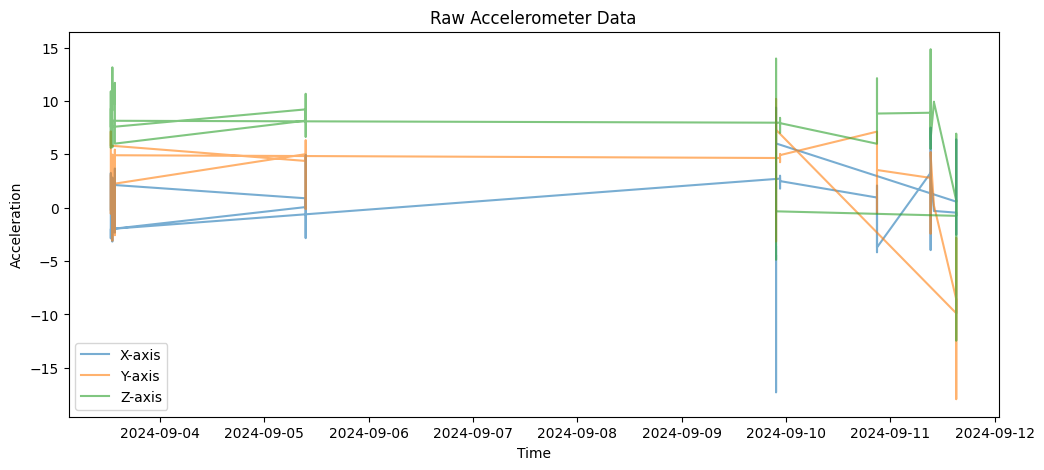

In [30]:
plt.figure(figsize=(12,5))
plt.plot(df['timestamp'], df['x'], label='X-axis', alpha=0.6)
plt.plot(df['timestamp'], df['y'], label='Y-axis', alpha=0.6)
plt.plot(df['timestamp'], df['z'], label='Z-axis', alpha=0.6)
plt.title("Raw Accelerometer Data")
plt.xlabel("Time")
plt.ylabel("Acceleration")
plt.legend()
plt.show()

This code cell visualises the unprocessed accelerometer data across the three spatial axes (X, Y, and Z) over time. Plotting the raw signals provides an initial understanding of movement intensity, variability, and potential noise characteristics present in the data. This exploratory visualisation is essential for identifying artefacts, abrupt spikes, or irregular patterns that may influence filtering and feature extraction decisions. Displaying all axes together allows direct comparison of directional motion and supports informed preprocessing choices.

# Comparison of Raw and Filtered Accelerometer Signal

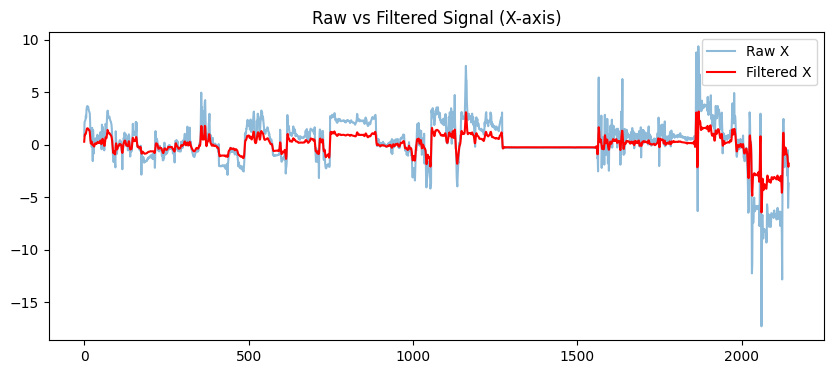

In [31]:
plt.figure(figsize=(10,4))
plt.plot(df['x'], label='Raw X', alpha=0.5)
plt.plot(df['x_filt'], label='Filtered X', color='red')
plt.title("Raw vs Filtered Signal (X-axis)")
plt.legend()
plt.show()

This code cell compares the original and low-pass filtered accelerometer signal along the X-axis. Plotting both signals together highlights the effect of the Butterworth filter in reducing high-frequency noise while preserving the underlying movement trend. This visual comparison validates the effectiveness of the signal processing step and confirms that meaningful motion information is retained. Such verification is important before proceeding to feature extraction, as excessive filtering could distort clinically or behaviourally relevant patterns.

# Distribution of X-Axis Variability Across Activities

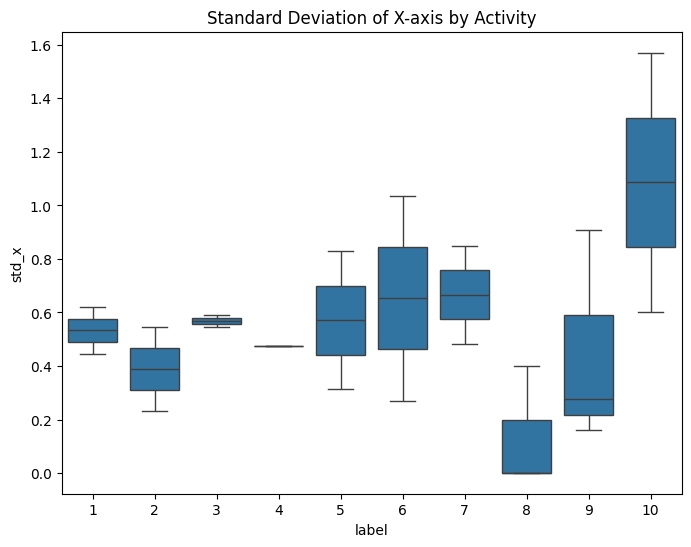

In [32]:
plt.figure(figsize=(8,6))
sns.boxplot(x='label', y='std_x', data=feat_df)
plt.title("Standard Deviation of X-axis by Activity")
plt.show()

This code cell visualises the distribution of X-axis acceleration variability for each activity class using a boxplot. The standard deviation feature represents movement variability within each window and is a key indicator of activity intensity and motion consistency. Comparing distributions across activity labels helps identify discriminative patterns and assess feature relevance for classification. Boxplots also highlight outliers and class overlap, supporting informed decisions on feature selection and model suitability.

# Feature Correlation Analysis

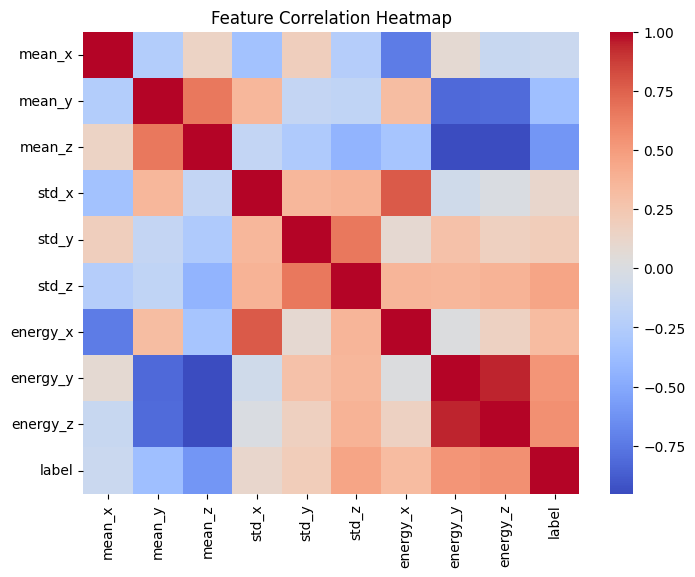

In [33]:
plt.figure(figsize=(8,6))
sns.heatmap(feat_df.corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

This code cell generates a heatmap to visualise pairwise correlations among the extracted features. Correlation analysis helps identify strongly related or redundant features that may not contribute additional predictive value. By examining the strength and direction of correlations, this step supports feature selection and dimensionality reduction decisions. Visualising correlations also aids interpretability by revealing relationships between statistical and energy-based features, helping to refine the feature set for more efficient and robust machine learning models.

# Three-Dimensional Feature Space Visualisation

In [34]:
fig = px.scatter_3d(feat_df, x='mean_x', y='mean_y', z='mean_z',
                    color=feat_df['label'].astype(str),
                    title="3D Feature Space by Activity Type")
fig.show()

This code cell creates an interactive three-dimensional scatter plot to visualise the distribution of activity windows in feature space using the mean acceleration values along the X, Y, and Z axes. Colour-coding by activity label enables visual assessment of class separation and overlap. This exploratory analysis helps evaluate the discriminative power of the selected features and provides intuitive insight into how different activities cluster in multidimensional space, supporting model selection and feature engineering decisions.

# Supervised Classification Using SVM


In [35]:
X = feat_df.drop('label', axis=1)
y = feat_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = SVC(kernel='rbf', C=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))


--- Classification Report ---
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.50      1.00      0.67         1

    accuracy                           0.14         7
   macro avg       0.06      0.12      0.08         7
weighted avg       0.07      0.14      0.10         7



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-p

This code cell prepares the extracted feature set for supervised learning by separating predictor variables from the target activity labels. The dataset is then split into training and testing subsets to enable unbiased model evaluation. A Support Vector Machine classifier with a radial basis function kernel is trained on the training data to capture non-linear decision boundaries. Predictions are generated for the test set, and a classification report is produced to summarise model performance in terms of precision, recall, F1-score, and overall accuracy across activity classes.

# Confusion Matrix Visualisation

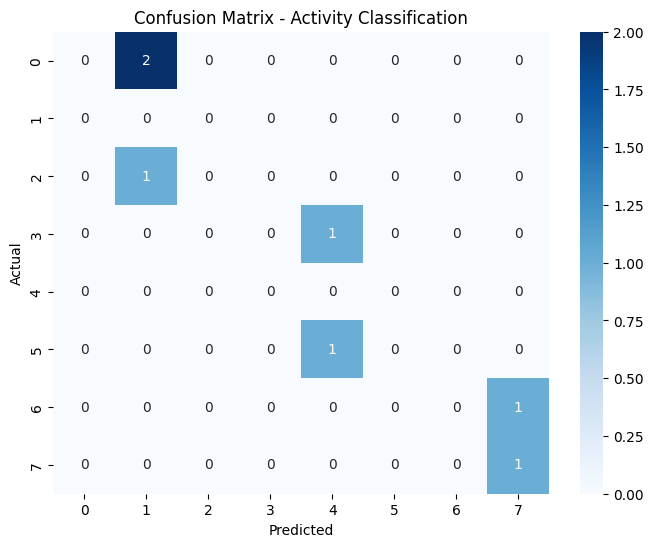

In [36]:

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Activity Classification")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

This code cell visualises the confusion matrix generated from the support vector machine classification results. The heatmap displays the number of correct and incorrect predictions for each activity class, enabling detailed assessment of class-wise performance. Annotated cell values improve interpretability by showing exact prediction counts. This visual evaluation highlights common misclassification patterns, supports error analysis, and complements numerical performance metrics by providing intuitive insight into the model’s strengths and limitations.